In [1]:
import numpy as np
import torch
import random
import os
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import string
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchtext.vocab import GloVe
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
from torch.autograd import Variable
from torchvision.utils import save_image
from IPython.core.display import Image, display

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device} is used")

# seed everything
seed = 1
random.seed(seed)
os.environ['PYTHONASSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
#os.environ['WANDB_CONSOLE'] = 'off'

cuda is used


In [2]:
# Read the data
training = pd.read_csv('../input/commonlitreadabilityprize/train.csv').to_numpy()
blind_test = pd.read_csv('../input/commonlitreadabilityprize/test.csv').to_numpy()
full_training = pd.read_csv('../input/commonlitreadabilityprize/train.csv').to_numpy()

# TODO: Remove to train on full dataset
#training = training[:10, :]

training = np.random.permutation(training)
print(training.shape, blind_test.shape, full_training.shape)

(2834, 6) (7, 4) (2834, 6)


In [3]:
# id,url_legal,license,excerpt,target,standard_error

# We have 5 features (id,url_legal,license,excerpt,standard_error) and 1 output 'target'

# For our model we'll only use the excerpt as a feature
training_X = training[:, 3]
training_Y = training[:, 4]
print('training shape =', training_X.shape, training_Y.shape)

full_training_X = full_training[:, 3]
full_training_Y = full_training[:, 4]
print('Real training shape =', full_training_X.shape, full_training_Y.shape)

blind_test_X = blind_test[:, 3]
print('BLIND test shape =', blind_test_X.shape)

training shape = (2834,) (2834,)
Real training shape = (2834,) (2834,)
BLIND test shape = (7,)


In [4]:
print(training_X[0])
print('\nTarget =', training_Y[0])

Frederick Fleet, who was lookout in the crow's nest of the Titanic when the giant liner smashed into the iceberg, made oath that not a single lookout on the Titanic was provided with marine glasses and declared that had his request for such glasses in Southampton not been refused the Titanic might yet be afloat. "I could easily have sighted the iceberg with marine glasses in plenty of time to have the vessel steered out of the way." said Fleet, and gave in detail the request he made in Southampton for them. Although all other liners are so provided, Fleet swore, his request was flatly refused and he was told there were no glasses for him.
Third Officer Pittman admitted that the Titanic had been warned that icebergs were prevalent, but said he did not see any on the Sunday of the disaster. He declared that in his 14 years' experience he had seen only one iceberg before.

Target = -0.952408653


### Turning excerpts into Tensors

Map each word to the its glove embeddings ID

In [5]:
import re
from torchtext import data, datasets, vocab
import codecs
from tqdm import tqdm

embedding_dim = 300
#glove = GloVe(name="840B", dim=embedding_dim)

GLOVE_EMB = '../input/glove840b300dtxt/glove.840B.300d.txt'
EMBEDDING_DIM = 300
embeddings_index = {}
f = codecs.open(GLOVE_EMB, encoding='utf-8')
for line in tqdm(f):
    values = line.split(" ")
    word = value = values[0]
    coefs = np.asarray(values[1:301], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print(embeddings_index['and'])

# Turn a line of words into the curresponding indices
def lineToTensor(line):
    # Split a string into array of words and punctation
    # "Much, fun." => ["Much", ",", "fun", "."]
    words = re.findall(r"[\w']+|[.,!?;]", line)
    tensor = torch.tensor([embeddings_index[w] for w in words if w in embeddings_index])
    return tensor

print(lineToTensor(training_X[0]))

2196019it [06:18, 5800.84it/s]


[-1.8567e-01  6.6008e-02 -2.5209e-01 -1.1725e-01  2.6513e-01  6.4908e-02
  1.2291e-01 -9.3979e-02  2.4321e-02  2.4926e+00 -1.7916e-02 -7.1218e-02
 -2.4782e-01 -2.6237e-01 -2.2460e-01 -2.1961e-01 -1.2927e-01  1.0867e+00
 -6.6072e-01 -3.1617e-02 -5.7328e-02  5.6903e-02 -2.7939e-01 -3.9825e-01
  1.4251e-01 -8.5146e-02 -1.4779e-01  5.5067e-02 -2.8687e-03 -2.0917e-01
 -7.0735e-02  2.2577e-01 -1.5881e-01 -1.0395e-01  9.7110e-02 -5.6251e-01
 -3.2929e-01 -2.0853e-01  9.8711e-03  4.9777e-02  1.4883e-03  1.5884e-01
  4.2771e-02 -2.6956e-03 -2.4620e-02 -1.9213e-01 -2.2556e-01  1.0838e-01
  9.0086e-02 -1.3291e-01  3.2559e-01 -1.7038e-01 -1.0990e-01 -2.3986e-01
 -2.4289e-02  1.4656e-02 -2.3700e-01  8.4828e-02 -3.5982e-01 -7.6746e-02
  4.8909e-02  1.1431e-01 -2.1013e-01  2.4765e-01 -1.7531e-02 -1.4028e-01
  4.6191e-02  2.2972e-01  1.1750e-01  1.2724e-01  1.2992e-02  4.5870e-01
  4.1085e-01  3.9106e-02  1.5713e-01 -1.8376e-01  2.6834e-01  5.6662e-02
  1.6844e-01 -5.3788e-02 -9.1892e-02  1.1193e-01 -8

In [6]:
# We want the entire dataset encoded with the glove embeddings
# So, the final size will be (n_samples, 1, excerpt_length, embedding_dim) (extra dimension 1 inserted for pytorch batch)
# Since a tensor has fixed size we pad the sequences to ensure all have the same length.

# Get the max excerpt length and encode the training set
max_excerpt_len = len(max(training_X, key=len))
enc_training_X = np.zeros((training_X.shape[0], 1, max_excerpt_len, embedding_dim))
training_lengths = []
for i, x in enumerate(training_X):
    enc_x = lineToTensor(x)
    enc_training_X[i, 0, :enc_x.shape[0]] = enc_x
    training_lengths.append(enc_x.shape[0])

print('encoded Training shape =',enc_training_X.shape)


max_excerpt_len = len(max(full_training_X, key=len))
enc_full_training_X = np.zeros((full_training_X.shape[0], 1, max_excerpt_len,embedding_dim))
full_training_lengths = []
for i, x in enumerate(full_training_X):
    enc_x = lineToTensor(x)
    enc_full_training_X[i, 0, :enc_x.shape[0]] = enc_x
    full_training_lengths.append(enc_x.shape[0])

print('encoded Real/Full Training shape =',enc_full_training_X.shape)


max_excerpt_len = len(max(blind_test_X, key=len))
enc_blind_test_X = np.zeros((blind_test_X.shape[0], 1, max_excerpt_len,embedding_dim))
blind_test_lengths = []
for i, x in enumerate(blind_test_X):
    enc_x = lineToTensor(x)
    enc_blind_test_X[i, 0, :enc_x.shape[0]] = enc_x
    blind_test_lengths.append(enc_x.shape[0])

print('enc. Test shape =', enc_blind_test_X.shape)

encoded Training shape = (2834, 1, 1341, 300)
encoded Real/Full Training shape = (2834, 1, 1341, 300)
enc. Test shape = (7, 1, 1144, 300)


In [7]:
from math import floor
#Utility function to get a random sample
def randomTrainingExample():
    i = np.random.randint(0, training_X.shape[0])
    excerpt_tensor = lineToTensor(training_X[i])
    target_tensor = torch.tensor(training_Y[i], dtype=torch.float)
    return excerpt_tensor, target_tensor

randomTrainingExample()

(tensor([[-0.3082, -0.0424, -0.1774,  ...,  0.1793,  0.0658,  0.0419],
         [ 0.0852,  0.5089, -0.0883,  ...,  0.4368,  0.2978, -0.0882],
         [ 0.8461,  0.0897,  0.1433,  ...,  0.3759,  0.0255,  0.1606],
         ...,
         [ 0.6164, -0.2851, -0.6487,  ...,  0.1159,  0.0657,  0.0450],
         [-0.0802, -0.2603, -0.0466,  ..., -0.4782,  0.0459, -0.2130],
         [ 0.0120,  0.2075, -0.1258,  ...,  0.1387, -0.3605, -0.0350]]),
 tensor(-0.5843))

In [8]:
class CommonLitDataset(Dataset):
    # X: numpy matrix (n_samples, 1, excerpt_length, embedding_dim)
    def __init__(self, X, Y, lengths):
        self.X = X
        self.Y = Y
        self.lengths = lengths

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return (torch.tensor(self.X[idx][0]).float(), self.lengths[idx]), torch.tensor(self.Y[idx]).float()

In [9]:
# Define the model

n_gaussians = 20
class MDNLSTM(nn.Module):
    def __init__(self, hidden_dim):
        super(MDNLSTM, self).__init__()
        self.z_size = 1
        self.n_gaussians = n_gaussians
        self.n_layers = 3
        self.n_hidden = hidden_dim

        self.gru = nn.GRU(embedding_dim, self.n_hidden, self.n_layers, batch_first=True, dropout=0.2, bidirectional=True)
        self.fc1 = nn.Linear(self.n_hidden, self.n_gaussians*self.z_size)
        self.fc2 = nn.Linear(self.n_hidden, self.n_gaussians*self.z_size)
        self.fc3 = nn.Linear(self.n_hidden, self.n_gaussians*self.z_size)

    def get_mixture_coef(self, y, rollout_length):
        # y.shape = torch.Size([3, 16, 256]) 
        pi, mu, sigma = self.fc1(y), self.fc2(y), self.fc3(y)
        
        pi = pi.view(-1, self.n_gaussians, self.z_size)
        mu = mu.view(-1, self.n_gaussians, self.z_size)
        sigma = sigma.view(-1, self.n_gaussians, self.z_size)
        
        pi = F.softmax(pi, 1)
        sigma = torch.exp(sigma)
        return pi, mu, sigma
        
    def forward(self, x, sequence_length):
        # Forward propagate gru
        x = pack_padded_sequence(x, sequence_length, batch_first=True, enforce_sorted=False)
        out, h = self.gru(x)
        #seq_unpacked, lens_unpacked = pad_packed_sequence(y, batch_first=True)
        pi, mu, sigma = self.get_mixture_coef(h[-1], sequence_length)
        return (pi, mu, sigma), h
    
    def init_hidden(self, bsz):
        return (torch.zeros(self.n_layers, bsz, self.n_hidden).to(device),
                torch.zeros(self.n_layers, bsz, self.n_hidden).to(device))
        
    # old

    # def forward(self, x, sequence_length):
    #     x_pack = pack_padded_sequence(x, sequence_length, batch_first=True, enforce_sorted=False)
    #     lstm_out, ht = self.gru(x_pack)
    #     return self.linear(ht[-1])

    # def initHidden(self, batch_size):
    #     return (torch.zeros(1, batch_size, self.hidden_dim), torch.zeros(1, batch_size, self.hidden_dim))


In [10]:
def mdn_loss_fn(y, pi, mu, sigma):
    # pi \in 16 x 5 x 1
    # 16 = batch size, 5 gaussians
    m = torch.distributions.Normal(loc=mu, scale=sigma)
    loss = torch.exp(m.log_prob(y))
    loss = torch.sum(loss * pi, dim=2)
    loss = -torch.log(loss)
    return loss.mean()

def criterion(y, pi, mu, sigma):
    y = torch.unsqueeze(y, 1)
    y = torch.unsqueeze(y, 1)
    #print(y.shape)
    return mdn_loss_fn(y, pi, mu, sigma)

In [11]:
def compute_mse(model, generator):
    model.eval()
    r = 0.0
    error = nn.MSELoss(reduction='sum')
    n = 0
    for (x, seq_len), y in generator:
        x, targets_batch = x.to(device), y.to(device)

        batch_size = x.shape[0]
        n += batch_size

        (pi, mu, sigma), hidden = mdnlstm(x, seq_len)
        y_preds = [torch.normal(mu, sigma)[:, i, :] for i in range(n_gaussians)]
        pred = torch.zeros((batch_size, 1)).to(device)
        for i, gauss_out in enumerate(y_preds):
            # gauss_out \in batch_size, 1
            pred += gauss_out
        mse = error(torch.unsqueeze(targets_batch, 1), pred / n_gaussians)

        r += mse.item()
    return r / n

In [12]:
import time
from math import floor, inf

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()
print_every = 1
plot_every = 1


BATCH_SIZE = 64     # batch = 16
hidden_dim = 256    # 256
epochs = 30          # 75
lr = 0.0005         # 0.00003
weight_decay = 1e-7 # 1e-7

# test_error = 0.61

mdnlstm = MDNLSTM(hidden_dim).to(device)

parameters = filter(lambda p: p.requires_grad, mdnlstm.parameters())
optimizer = torch.optim.Adam(parameters, lr=lr, weight_decay=weight_decay)

params = {'batch_size': BATCH_SIZE,
          'shuffle': True,
          'num_workers': 0}

commonlit_dataset1 = CommonLitDataset(enc_training_X[400:], training_Y[400:], training_lengths[400:])
training_generator = torch.utils.data.DataLoader(commonlit_dataset1, **params)

commonlit_dataset2 = CommonLitDataset(enc_training_X[:400], training_Y[:400], training_lengths[:400])
validation_generator = torch.utils.data.DataLoader(commonlit_dataset2, **params)

# Early stopping logic
val_losses = []
best_val_error = inf
best_val_epoch = 0

for iter in range(1, epochs + 1):
    total = 0
    current_loss = 0.0
    mdnlstm.train()
    for (x, seq_len), y in training_generator:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        (pi, mu, sigma), hidden = mdnlstm(x, seq_len)
        loss = criterion(y, pi, mu, sigma)
        
        # Backward and optimize
        mdnlstm.zero_grad()
        loss.backward()
        # clip_grad_norm_(mdnlstm.parameters(), 0.5)
        optimizer.step()

        current_loss += loss.item()*y.shape[0]
        total += y.shape[0]

    # Mean squared error
    current_loss /= total # -log prob
    #current_loss = compute_mse(mdnlstm, training_generator)

    current_val_error = compute_mse(mdnlstm, validation_generator)
    val_losses.append(current_val_error)
    if current_val_error < best_val_error:
        best_val_error = current_val_error
        best_val_epoch = iter

    # Print iter number, loss
    if iter % print_every == 0:
        print('Iteration %d | %d%% (%s) Loss = %.4f Val RMSE = %.4f' % (iter, iter / epochs * 100, timeSince(start), current_loss, np.sqrt(current_val_error)))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

Iteration 1 | 3% (0m 21s) Loss = 4.4217 Val RMSE = 0.8358
Iteration 2 | 6% (0m 35s) Loss = 4.1571 Val RMSE = 0.8078
Iteration 3 | 10% (0m 49s) Loss = 4.0751 Val RMSE = 0.7065
Iteration 4 | 13% (1m 4s) Loss = 3.9762 Val RMSE = 0.6956
Iteration 5 | 16% (1m 18s) Loss = 3.9525 Val RMSE = 0.6573
Iteration 6 | 20% (1m 33s) Loss = 3.8920 Val RMSE = 0.6714
Iteration 7 | 23% (1m 47s) Loss = 3.9083 Val RMSE = 0.6441
Iteration 8 | 26% (2m 2s) Loss = 3.8181 Val RMSE = 0.6491
Iteration 9 | 30% (2m 16s) Loss = 3.7915 Val RMSE = 0.6416
Iteration 10 | 33% (2m 31s) Loss = 3.7610 Val RMSE = 0.6285
Iteration 11 | 36% (2m 45s) Loss = 3.7060 Val RMSE = 0.6475
Iteration 12 | 40% (2m 59s) Loss = 3.6719 Val RMSE = 0.7691
Iteration 13 | 43% (3m 14s) Loss = 3.6544 Val RMSE = 0.8469
Iteration 14 | 46% (3m 28s) Loss = 3.8607 Val RMSE = 0.6421
Iteration 15 | 50% (3m 42s) Loss = 3.5527 Val RMSE = 0.7088
Iteration 16 | 53% (3m 57s) Loss = 3.5283 Val RMSE = 0.7117
Iteration 17 | 56% (4m 11s) Loss = 3.5573 Val RMSE = 

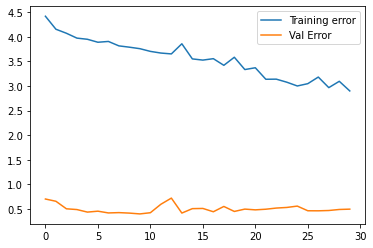

In [13]:
# Plot the learning curve
plt.figure()
plt.plot(all_losses, label='Training error')
plt.plot(val_losses, label='Val Error')
plt.legend()

## Retrain the model on the full train dataset

In [14]:
params = {'batch_size': BATCH_SIZE,
          'shuffle': True,
          'num_workers': 0}

commonlit_dataset3 = CommonLitDataset(enc_full_training_X, full_training_Y, full_training_lengths)
full_training_generator = torch.utils.data.DataLoader(commonlit_dataset3, **params)

final_model = MDNLSTM(hidden_dim).to(device)

epochs = best_val_epoch

all_losses = []

start = time.time()

parameters = filter(lambda p: p.requires_grad, final_model.parameters())
optimizer = torch.optim.Adam(parameters, lr=lr)

for iter in range(1, epochs + 1):
    total = 0
    current_loss = 0.0
    final_model.train()
    for (x, seq_len), y in full_training_generator:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        (pi, mu, sigma), hidden = final_model(x, seq_len)
        loss = criterion(y, pi, mu, sigma)
        
        # Backward and optimize
        mdnlstm.zero_grad()
        loss.backward()
        # clip_grad_norm_(mdnlstm.parameters(), 0.5)
        optimizer.step()

        current_loss += loss.item()*y.shape[0]
        total += y.shape[0]

    # Mean squared error
    current_loss /= total

    # Print iter number, loss
    if iter % print_every == 0:
        print('Iteration %d | %d%% (%s) Loss = %.4f' % (iter, iter / epochs * 100, timeSince(start), current_loss))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

Iteration 1 | 10% (0m 16s) Loss = 4.4191
Iteration 2 | 20% (0m 30s) Loss = 4.1179
Iteration 3 | 30% (0m 45s) Loss = 3.9974
Iteration 4 | 40% (0m 59s) Loss = 3.9468
Iteration 5 | 50% (1m 13s) Loss = 3.8651
Iteration 6 | 60% (1m 28s) Loss = 3.8398
Iteration 7 | 70% (1m 42s) Loss = 3.7982
Iteration 8 | 80% (1m 56s) Loss = 3.7448
Iteration 9 | 90% (2m 10s) Loss = 3.6932
Iteration 10 | 100% (2m 24s) Loss = 3.6505


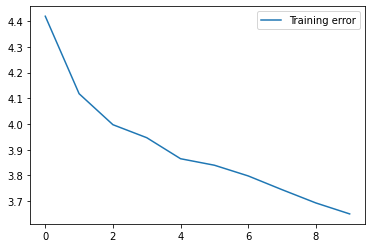

In [15]:
# Plot the learning curve
plt.figure()
plt.plot(all_losses, label='Training error')
plt.legend()

## Evaluate the model

In [16]:
blind_test_params = {'batch_size': 1,
          'shuffle': False,
          'num_workers': 0}

blind_test_dataset = CommonLitDataset(enc_blind_test_X, np.zeros(enc_blind_test_X.shape), blind_test_lengths)
blind_test_generator = torch.utils.data.DataLoader(blind_test_dataset, **blind_test_params)

In [17]:

print('Training RMSE =', np.sqrt(compute_mse(final_model, full_training_generator) / enc_training_X.shape[0]))
    

Training RMSE = 0.00678418636396892


# Compute blind test set outputs

In [18]:
outputs = []
with torch.no_grad():
    for i, ((x, seq_len), targets_batch) in enumerate(blind_test_generator):
        excerpts_batch = x.to(device)

        batch_size = excerpts_batch.shape[0]

        (pi, mu, sigma), hidden = final_model(excerpts_batch, seq_len)
        
        y_preds = [torch.normal(mu, sigma)[:, i, :] for i in range(n_gaussians)]
        pred = torch.zeros((batch_size, 1)).to(device)
        for k, gauss_out in enumerate(y_preds):
            pred += gauss_out
        out = pred / n_gaussians
        
        id = blind_test[i, 0]
        print(id, out.item())
        outputs.append((id, out.item()))

# Save outputs to submission.csv
if True:
    with open('submission.csv', 'w') as f:
        f.write('id,target\n')
        for id, o in outputs:
            f.write(id+','+str(o)+'\n')

c0f722661 -1.7624658346176147
f0953f0a5 0.3321051299571991
0df072751 -0.5137155652046204
04caf4e0c -2.074028730392456
0e63f8bea -2.2476508617401123
12537fe78 -2.277606964111328
965e592c0 -0.206984743475914


 NEXT:

https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
 
 
 
    Try the nn.LSTM and nn.GRU layers
    Combine multiple of these RNNs as a higher level network
